<a href="https://colab.research.google.com/github/johanjun/dacon_growthperiod/blob/main/training1211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from tqdm import tqdm

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [4]:
root_dir = '/content/drive/MyDrive/dacon_growthperiod/open'
train_data_dir = os.path.join(root_dir, 'train_dataset')
test_data_dir = os.path.join(root_dir, 'test_dataset')

In [5]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
train_dir = os.path.join(train_data_dir, 'train')
val_dir = os.path.join(train_data_dir, 'validation')

tfr_dir = os.path.join(train_data_dir, 'tfrecord')

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [7]:
n_train = 11690
n_val = 2923

In [8]:
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [9]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'delta': tf.io.FixedLenFeature([], tf.string),
              'time_delta': tf.io.FixedLenFeature([], tf.int64)         
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    delta = tf.io.decode_raw(parsed_features['delta'], tf.uint8)    
    delta = tf.reshape(delta, [IMG_SIZE, IMG_SIZE])
    delta = tf.cast(delta, tf.float32)/255.

    time_delta = tf.cast(parsed_features['time_delta'], tf.int64)

    return delta, time_delta

In [10]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [11]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

tf.Tensor(27, shape=(), dtype=int64)


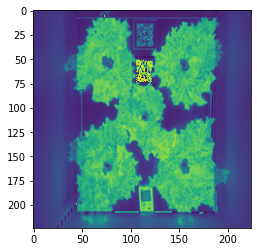

tf.Tensor(3, shape=(), dtype=int64)


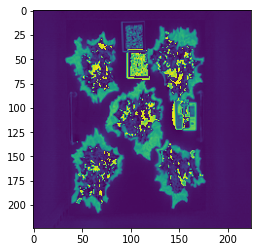

tf.Tensor(2, shape=(), dtype=int64)


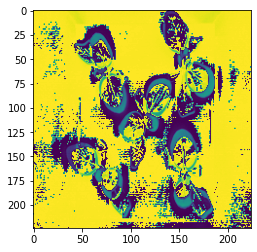

tf.Tensor(11, shape=(), dtype=int64)


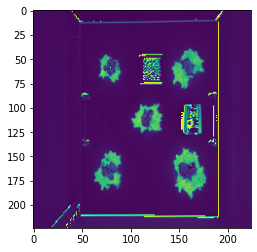

tf.Tensor(6, shape=(), dtype=int64)


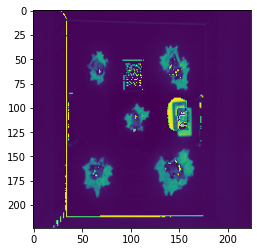

tf.Tensor(1, shape=(), dtype=int64)


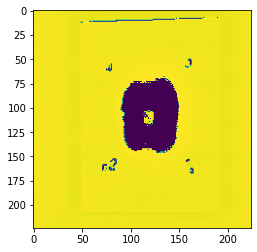

tf.Tensor(29, shape=(), dtype=int64)


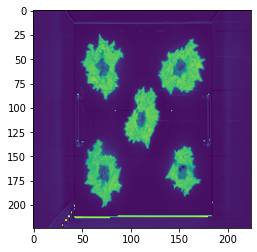

tf.Tensor(14, shape=(), dtype=int64)


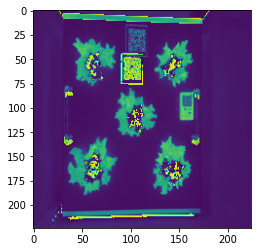

tf.Tensor(21, shape=(), dtype=int64)


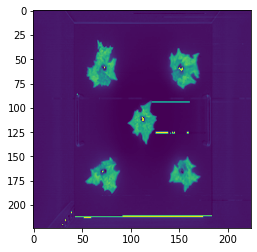

tf.Tensor(5, shape=(), dtype=int64)


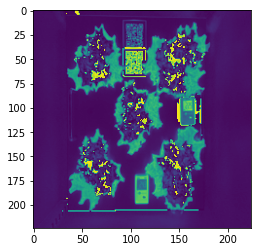

In [12]:
for delta, time_delta in train_dataset.take(10):
  print(time_delta[0])
  plt.imshow(delta[0])
  plt.show()

In [13]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [14]:
# mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [15]:
# def create_mv_model():
#   model = models.Sequential()
#   model.add(mobilenetv2)
#   model.add(GlobalAveragePooling2D())
#   model.add(Dense(128, activation='relu'))
#   model.add(Dense(64, activation='relu'))
#   model.add(Dense(32, activation='relu'))
#   model.add(Dense(1))
#   return model

In [16]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

In [17]:
## Create model, compile & summary
model = create_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='mse',
              metrics=['mse'])

In [18]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
292/292 [==============================] - 26s 55ms/step - loss: 19.4829 - mse: 19.4829 - val_loss: 106.8897 - val_mse: 106.8897
Epoch 2/20
292/292 [==============================] - 16s 49ms/step - loss: 9.7136 - mse: 9.7136 - val_loss: 6.7081 - val_mse: 6.7081
Epoch 3/20
292/292 [==============================] - 16s 49ms/step - loss: 8.0406 - mse: 8.0406 - val_loss: 4.7512 - val_mse: 4.7512
Epoch 4/20
292/292 [==============================] - 16s 49ms/step - loss: 7.9966 - mse: 7.9966 - val_loss: 3.2751 - val_mse: 3.2751
Epoch 5/20
292/292 [==============================] - 16s 49ms/step - loss: 7.2101 - mse: 7.2101 - val_loss: 2.8294 - val_mse: 2.8294
Epoch 6/20
292/292 [==============================] - 16s 49ms/step - loss: 6.0127 - mse: 6.0127 - val_loss: 3.3574 - val_mse: 3.3574
Epoch 7/20
292/292 [==============================] - 16s 49ms/step - loss: 5.7343 - mse: 5.7343 - val_loss: 2.0876 - val_mse: 2.0876
Epoch 8/20
292/292 [==============================] - 16

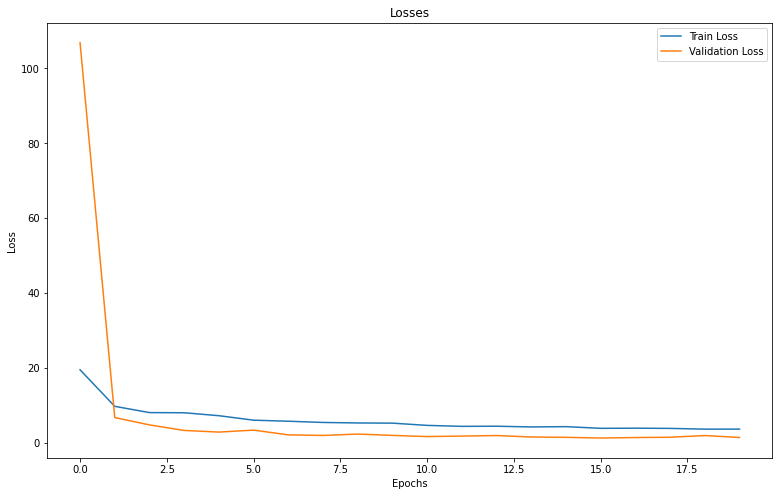

In [19]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

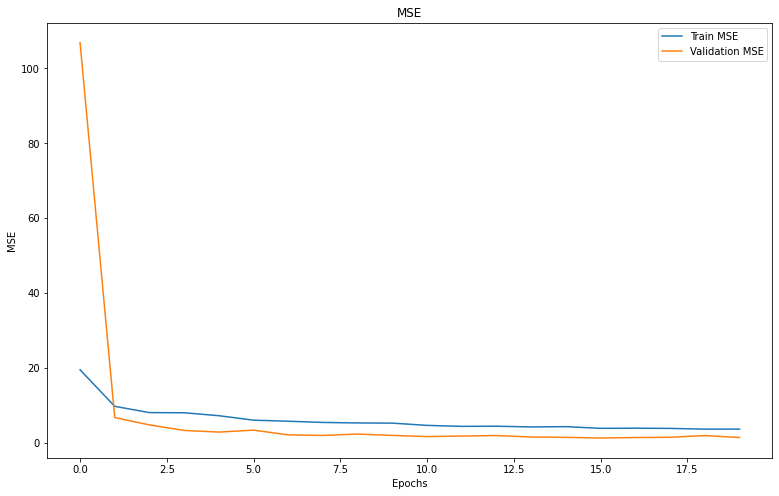

In [20]:
plt.figure(figsize = (13,8))
plt.plot(history.history["mse"], label = "Train MSE")
plt.plot(history.history["val_mse"],label = "Validation MSE")
plt.title("MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

tf.Tensor(15, shape=(), dtype=int64)


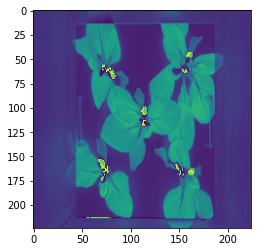

[14.823748]
tf.Tensor(7, shape=(), dtype=int64)


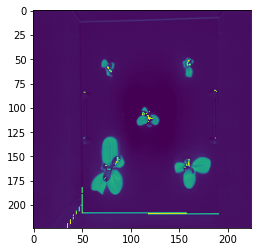

[7.0329523]
tf.Tensor(16, shape=(), dtype=int64)


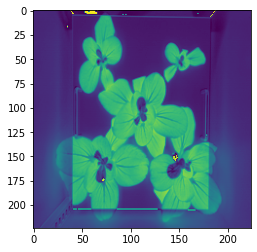

[15.932989]
tf.Tensor(13, shape=(), dtype=int64)


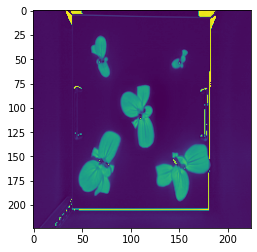

[13.644655]
tf.Tensor(15, shape=(), dtype=int64)


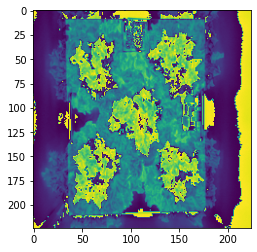

[14.63415]


In [36]:
for delta, time_delta in train_dataset.take(5):
  print(time_delta[5])
  plt.imshow(delta[5])
  plt.show()

  pred = model.predict(delta)
  print(pred[5])

#pred

In [21]:
test_set = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x: '/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/' + x.split('_')[1] + '/' + x.split('_')[2])
test_set['l_path'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['r_path'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'

In [22]:
test_set.head()

,idx,before_file_path,after_file_path,l_root,r_root,l_path,r_path
0,0,idx_LT_1003_00341,idx_LT_1003_00154,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
1,1,idx_LT_1003_00592,idx_LT_1003_00687,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
2,2,idx_BC_1100_00445,idx_BC_1100_00840,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
3,3,idx_BC_1112_00229,idx_BC_1112_00105,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...
4,4,idx_LT_1088_00681,idx_LT_1088_00698,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...,/content/drive/MyDrive/dacon_growthperiod/open...


In [23]:
print(test_set.iloc[0].l_root)
test_set.iloc[0].l_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00341.png'

In [24]:
print(test_set.iloc[0].r_root)
test_set.iloc[0].r_path

/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003


'/content/drive/MyDrive/dacon_growthperiod/open/test_dataset/LT/1003/idx_LT_1003_00154.png'

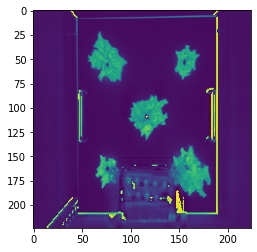

[[20.970018]]


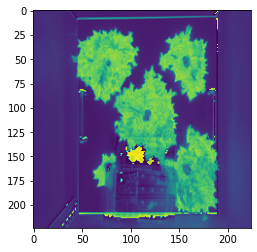

[[23.758072]]


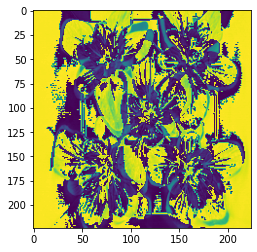

[[2.2284167]]


In [31]:
for i, v in test_set[:3].iterrows():
  before_image = Image.open(v.l_path).convert("L")
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path).convert("L")
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)


  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE])
  delta = tf.cast(delta, tf.float32)/255

  plt.imshow(tf.reshape(delta, [IMG_SIZE, IMG_SIZE]))
  plt.show()

  pred = model.predict(delta)
  print(pred)

  

In [1]:
  len(test_set)

NameError: ignored

In [25]:
cd '/content/drive/MyDrive/dacon_growthperiod/open/works'

/content/drive/MyDrive/dacon_growthperiod/open/works


In [26]:
pred_res = []
delta_res = []
for i, v in tqdm(test_set.iterrows()):
  before_image = Image.open(v.l_path).convert("L")
  before_image = before_image.resize((224, 224))

  after_image = Image.open(v.r_path).convert("L")
  after_image = after_image.resize((224, 224))

  delta = np.array(before_image) - np.array(after_image)
  delta = tf.reshape(delta, [1, IMG_SIZE, IMG_SIZE])
  delta = tf.cast(delta, tf.float32)/255

  delta_res.append(delta)

  pred = model.predict(delta)
  pred_res.append(pred)

3960it [48:23,  1.36it/s]


In [27]:
import pickle
with open('delta(grayscale).pkl', 'wb') as f:
  pickle.dump(delta, f)

In [28]:
pred_res[:10]

[array([[19.760477]], dtype=float32),
 array([[20.844944]], dtype=float32),
 array([[1.9740436]], dtype=float32),
 array([[3.360506]], dtype=float32),
 array([[22.803883]], dtype=float32),
 array([[17.752024]], dtype=float32),
 array([[17.792387]], dtype=float32),
 array([[17.424562]], dtype=float32),
 array([[2.586994]], dtype=float32),
 array([[26.617605]], dtype=float32)]

In [29]:
ans = [float(p) for p in pred_res]

In [30]:
sub = pd.read_csv('/content/drive/MyDrive/dacon_growthperiod/open/sample_submission.csv')

In [31]:
sub['time_delta'] = pd.Series(ans)

In [32]:
sub.head()

,idx,time_delta
0,0,19.760477
1,1,20.844944
2,2,1.974044
3,3,3.360506
4,4,22.803883


In [33]:
cd '/content/drive/MyDrive/dacon_growthperiod/open/submission'

/content/drive/MyDrive/dacon_growthperiod/open/submission


In [34]:
sub.set_index('idx', drop=True, inplace=True)

In [35]:
sub.head()

,time_delta
idx,
0,19.760477
1,20.844944
2,1.974044
3,3.360506
4,22.803883


In [36]:
sub.to_csv('1211-1.csv')